In [ ]:
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import numpy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar10
from keras.layers import Add, Dense, Activation, BatchNormalization, Conv2D
from keras.layers import Flatten
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.utils import np_utils
from keras.initializers import glorot_uniform
%matplotlib inline

In [ ]:
model_type = 'vgg16'

In [ ]:
model_home_dir = os.path.join(os.getcwd(), 'CNN_TASK_ODED',"model_type")
print(model_home_dir)
if not os.path.isdir(model_home_dir):
    print('Inside mkdir')
    os.makedirs(model_home_dir)

/content/CNN_TASK_ODED/model_type
Inside mkdir


In [ ]:
#Defining Variables

#Data set information
DATASET = 'cifar-10'
num_classes = 2
input_shape=(32,32,3)
epochs = 200
lrate = 0.01
decay = lrate/epochs
batch_size = 32
seed = 7
np.random.seed(seed)

validate_dir = os.path.join("data","test")
train_dir = os.path.join("data","train")

# Prepare model model saving directory.
save_dir = os.path.join(model_home_dir, 'saved_models')

model_name = DATASET+'_'+'%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print("Model Type: ",model_type)
print("Model File: ",filepath)

Model Type:  vgg16
Model File:  /content/CNN_TASK_ODED/model_type/saved_models/cifar-10_vgg16_model.{epoch:03d}.h5


In [ ]:
def preprocess(img, label):
    return tf.image.resize(img, [HEIGHT, WIDTH]) / 255, label

HEIGHT = 32
WIDTH = 32
split = ['train[:85%]', 'train[85%:]']


trainDataset, testDataset = tfds.load('cats_vs_dogs',
                         split = split,
                         batch_size=1, 
                         as_supervised=True)



trainDataset = trainDataset.map(preprocess)
testDataset = testDataset.map(preprocess)

train = list(tfds.as_numpy(trainDataset))
test = list(tfds.as_numpy(testDataset))

X_train = [e[0][0].astype('float32') for e in train]
X_test = [e[0][0].astype('float32') for e in test]

X_train = numpy.stack(X_train)
X_test = numpy.stack(X_test)

y_train = [e[1][0] for e in train]
y_test = [e[1][0] for e in test]

y_train = numpy.stack(y_train).reshape((-1,1)) 
y_test = numpy.stack(y_test).reshape((-1,1)) 

print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteIVF4IM/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
(19773, 1) (3489, 1)
(19773, 32, 32, 3) (3489, 32, 32, 3)


------------------concatenate train-------------------


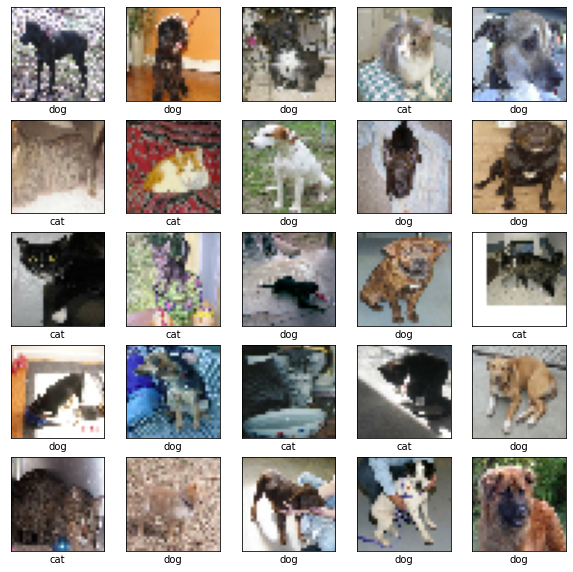

------------------concatenate test-------------------


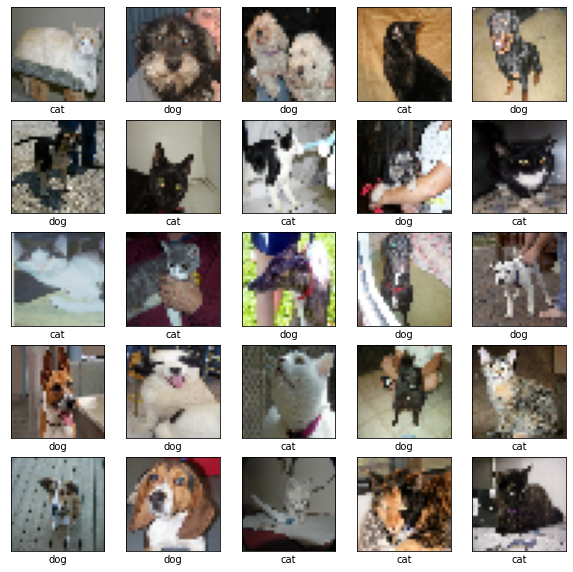

In [ ]:
class_names = ['cat', 'dog']

print("------------------concatenate train-------------------")
plt.figure(figsize=(10,10))
for i in range(25):
    j = random.randint(0,19773)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[j])
    plt.xlabel(class_names[y_train[j][0]])
plt.show()

print("------------------concatenate test-------------------")
plt.figure(figsize=(10,10))
for i in range(25):
    j = random.randint(0,3489) 
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[j])
    plt.xlabel(class_names[y_test[j][0]])
plt.show()

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


X_train_mean = np.mean(X_train)
X_train -= X_train_mean
X_test_mean = np.mean(X_test)
X_test -= X_test_mean

y_train = np_utils.to_categorical(y_train,)
y_test = np_utils.to_categorical(y_test,)
y_train = np.delete(y_train,1,1)
y_test = np.delete(y_test,1,1)
print(y_train.shape, y_test.shape)



(19773, 1) (3489, 1)


In [ ]:
from tensorflow.keras.layers import Dropout
def vgg16(input_shape=(32,32,3), num_classes=2):
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


  model.add(Dropout(0.8))

  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))

  return model

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [ ]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]


In [ ]:
 model = vgg16(input_shape,num_classes)

# Compile model

# optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss= 'binary_crossentropy' , optimizer=optimizer, metrics=['accuracy'])
print("Model Summary of ",model_type)
print(model.summary())



Model Summary of  vgg16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        9232      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 16)        2320      
                                

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Score trained model.
history = model.fit(X_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(X_test, y_test),
      shuffle=True,
      callbacks=callbacks)
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
Epoch 1/200
618/618 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.5917

618/618 [==============================] - 16s 12ms/step - loss: 0.6644 - accuracy: 0.5917 - val_loss: 0.6141 - val_accuracy: 0.6761 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
618/618 [==============================] - ETA: 0s - loss: 0.6037 - accuracy: 0.6731

618/618 [==============================] - 7s 12ms/step - loss: 0.6037 - accuracy: 0.6731 - val_loss: 0.5868 - val_accuracy: 0.6847 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
615/618 [============================>.] - ETA: 0s - loss: 0.5691 - accuracy: 0.7069

618/618 [==============================] - 7s 12ms/step - loss: 0.5689 - accuracy: 0.7070 - val_loss: 0.6198 - val_accuracy: 0.6512 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
614/618 [============================>.] - ETA: 0s - loss: 0.5410 - accuracy: 0.7264

618/618 [==============================] - 7s 11ms/step - loss: 0.5411 - accuracy: 0.7266 - val_loss: 0.5502 - val_accuracy: 0.7246 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
614/618 [============================>.] - ETA: 0s - loss: 0.5173 - accuracy: 0.7447

618/618 [==============================] - 7s 11ms/step - loss: 0.5173 - accuracy: 0.7449 - val_loss: 0.5051 - val_accuracy: 0.7515 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
615/618 [============================>.] - ETA: 0s - loss: 0.4950 - accuracy: 0.7580

618/618 [==============================] - 7s 11ms/step - loss: 0.4953 - accuracy: 0.7576 - val_loss: 0.5104 - val_accuracy: 0.7492 - lr: 0.0010
Learning rate:  0.001
Epoch 7/200
614/618 [============================>.] - ETA: 0s - loss: 0.4803 - accuracy: 0.7686

618/618 [==============================] - 7s 11ms/step - loss: 0.4799 - accuracy: 0.7691 - val_loss: 0.4850 - val_accuracy: 0.7615 - lr: 0.0010
Learning rate:  0.001
Epoch 8/200
617/618 [============================>.] - ETA: 0s - loss: 0.4679 - accuracy: 0.7778

618/618 [==============================] - 7s 11ms/step - loss: 0.4677 - accuracy: 0.7779 - val_loss: 0.4570 - val_accuracy: 0.7822 - lr: 0.0010
Learning rate:  0.001
Epoch 9/200
615/618 [============================>.] - ETA: 0s - loss: 0.4534 - accuracy: 0.7872

618/618 [==============================] - 7s 11ms/step - loss: 0.4532 - accuracy: 0.7874 - val_loss: 0.4645 - val_accuracy: 0.7827 - lr: 0.0010
Learning rate:  0.001
Epoch 10/200
617/618 [============================>.] - ETA: 0s - loss: 0.4440 - accuracy: 0.7899

618/618 [==============================] - 7s 11ms/step - loss: 0.4439 - accuracy: 0.7900 - val_loss: 0.4678 - val_accuracy: 0.7756 - lr: 0.0010
Learning rate:  0.001
Epoch 11/200
616/618 [============================>.] - ETA: 0s - loss: 0.4258 - accuracy: 0.8017

618/618 [==============================] - 7s 11ms/step - loss: 0.4256 - accuracy: 0.8019 - val_loss: 0.4442 - val_accuracy: 0.7919 - lr: 0.0010
Learning rate:  0.001
Epoch 12/200
616/618 [============================>.] - ETA: 0s - loss: 0.4178 - accuracy: 0.8051

618/618 [==============================] - 7s 11ms/step - loss: 0.4180 - accuracy: 0.8050 - val_loss: 0.4812 - val_accuracy: 0.7650 - lr: 0.0010
Learning rate:  0.001
Epoch 13/200
615/618 [============================>.] - ETA: 0s - loss: 0.4045 - accuracy: 0.8147

618/618 [==============================] - 7s 11ms/step - loss: 0.4042 - accuracy: 0.8148 - val_loss: 0.4699 - val_accuracy: 0.7676 - lr: 0.0010
Learning rate:  0.001
Epoch 14/200
615/618 [============================>.] - ETA: 0s - loss: 0.3924 - accuracy: 0.8207

618/618 [==============================] - 7s 11ms/step - loss: 0.3928 - accuracy: 0.8204 - val_loss: 0.5131 - val_accuracy: 0.7544 - lr: 0.0010
Learning rate:  0.001
Epoch 15/200
615/618 [============================>.] - ETA: 0s - loss: 0.3795 - accuracy: 0.8253

618/618 [==============================] - 7s 11ms/step - loss: 0.3793 - accuracy: 0.8255 - val_loss: 0.4656 - val_accuracy: 0.7959 - lr: 0.0010
Learning rate:  0.001
Epoch 16/200
618/618 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.8346

110/110 [==============================] - 0s 4ms/step - loss: 0.4442 - accuracy: 0.7919
Test loss: 0.44420668482780457
Test accuracy: 0.7919174432754517


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


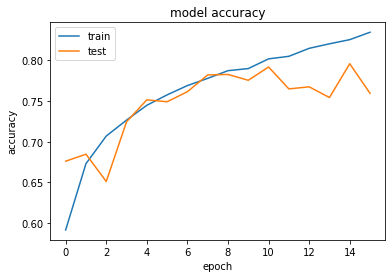

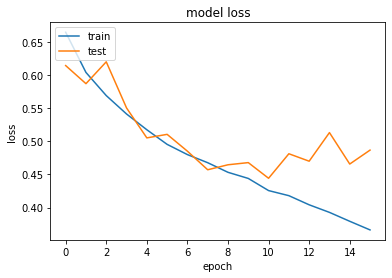

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

110/110 [==============================] - 0s 3ms/step


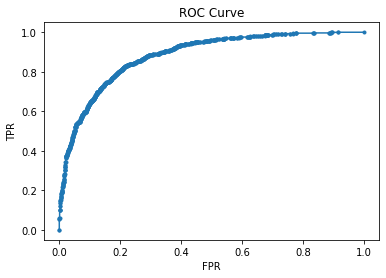

0.8826168049219767


In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test).ravel()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
plt.title('ROC Curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

print(auc_keras)

110/110 [==============================] - 0s 3ms/step


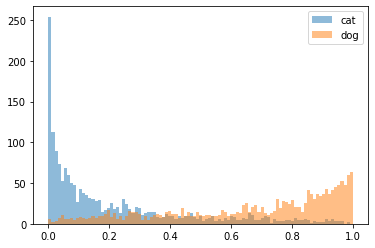

In [ ]:
from matplotlib import pyplot
predict_x=model.predict(X_test) 

cat_index = np.where(y_test.reshape(-1) == 0.)
cat = predict_x[cat_index]

dog_index = np.where(y_test.reshape(-1) == 1.)
dog = predict_x[dog_index]



bins = np.linspace(0, 1, 100)

pyplot.hist(cat, bins, alpha=0.5, label='cat')
pyplot.hist(dog, bins, alpha=0.5, label='dog')
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
print(len(dog))
print(len(cat))


1720
1769


In [ ]:
for X,Y in zip(predict_x,y_test):
    print("Model Score:", X, "actual score:", Y) 

Model Score: [0.79560775] actual score: [1.]
Model Score: [0.8772632] actual score: [0.]
Model Score: [0.22287802] actual score: [0.]
Model Score: [0.50570285] actual score: [1.]
Model Score: [0.21985555] actual score: [1.]
Model Score: [0.93398607] actual score: [1.]
Model Score: [0.21432512] actual score: [0.]
Model Score: [0.05558124] actual score: [0.]
Model Score: [0.26906312] actual score: [1.]
Model Score: [0.53350514] actual score: [1.]
Model Score: [0.09784032] actual score: [0.]
Model Score: [0.01744938] actual score: [0.]
Model Score: [0.7434968] actual score: [0.]
Model Score: [0.0916134] actual score: [0.]
Model Score: [0.02875496] actual score: [0.]
Model Score: [0.08601211] actual score: [0.]
Model Score: [0.27032155] actual score: [1.]
Model Score: [0.53260285] actual score: [0.]
Model Score: [0.14751709] actual score: [1.]
Model Score: [0.03580778] actual score: [0.]
Model Score: [0.9970988] actual score: [1.]
Model Score: [0.28376827] actual score: [1.]
Model Score: [